In [1]:
import numpy as np
from utils.get_images import get_images

In [2]:
# mnist path
mnist_path = './mnist/'

x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

In [3]:
# tomar los primeros 50k datos y reagrupar en un formato para que sea procesable por el modelo

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)/255
y_test = y_test_num.copy().reshape(10000, 1)

In [4]:
print(x_train.shape)

(50000, 784)


$z^1$ = $W^1X + b^1$

$a^1 = ReLu(z^1)$

$z^2$ = $W^2a + b^2$

$\hat{y} = \frac{e^{z^2_k}}{\sum_je^{z_j}}$

$\mathcal{L}(\hat{y}^i, y^i) = -y^iln(\hat{y}^i) = -ln(\hat{y}^i)$

$\mathcal{J}(w, b) = \frac{1}{num_samples}\sum_{i=1}^{num_samples}(-ln(\hat{y}^i))$

In [5]:
# para hacer eficiente el entrenamiento en las capas de la red, vamos a partir en mini bachs los datos
# crearíamos una matriz de 784xm donde m > 1, mayor a 1 dado que enviar m = 1 es enviar un sólo dato
# 1 < m < 50.000 se suelen usar potencias de 2 dado que son más eficientes computacionalmente

def create_minibatches(mb_size, x, y, shuffle = True):
    """
    x # muestras, 784
    y #muestras, 1
    shuffle: bandera que nos permite activar o no un muestreo aleatorio
    """
    assert x.shape[0] == y.shape[0]
    total_data =  x.shape[0]

    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]

    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))


In [6]:
# función para inicializar los parámetros, red de dos capas básica

def init_parameters(input_size, neurons):
    """
    input_size: number of input elements
    neurons: number neurons in layers ex. [200,10], 200 first layer, 10 second layer
    """

    w1 = np.random.randn(neurons[0], input_size) * 0.001 # para inicializarse deben ser números muy pequeños por eso el 0.001
    b1 = np.zeros((neurons[0], 1))

    w2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))

    return {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}


In [7]:
# prueba de init_parameters
parameters = init_parameters(28*28, [200, 10])
print(parameters['w1'].shape)
print(parameters['b1'].shape)
print(parameters['w2'].shape)

(200, 784)
(200, 1)
(10, 200)


$a^1 = ReLu(z^1)$

In [8]:
# elimina valores negativos y pasa positivos

def relu(x):
    return np.maximum(0,x)

$z^1$ = $W^1X + b^1$

$z^2$ = $W^2a + b^2$

In [9]:
# función de activación

def scores(x, parameters, activation_fcn):
    """
    x: dim #pixeles, #samples
    """
    z1 = parameters['w1'] @ x + parameters['b1'] # @ multiplicacion de matrices
    a1 = activation_fcn(z1) # función de activación
    z2 = parameters['w2'] @ a1 + parameters['b2']

    return z2, z1, a1
    

In [10]:
# prueba scores
scores_res, z1, a1 = scores(x_train[:64].T, parameters, relu) # datos transpuestos

softmax

$\hat{y} = \frac{e^{z^2_k}}{\sum_je^{z_j}}$

In [11]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores

    return probs


$\mathcal{L}(\hat{y}^i, y^i) = -y^iln(\hat{y}^i) = -ln(\hat{y}^i)$

$\mathcal{J}(w, b) = \frac{1}{num_samples}\sum_{i=1}^{num_samples}(-ln(\hat{y}^i))$

In [12]:
# función de perdida

def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)] # squeeze toma solo los elementos y no las columnas
    cost = np.sum(-np.log(y_hat))/ batch_size # función de costo, promedio de la función de perdida de cada elemento score

    return probs, cost

In [13]:
# función de retro propagación

def backward(probs, x, y, z1, a1, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # se toma la prob de la clase correcta 1 es la prob correcta
    dz2 = probs.copy()

    dw2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis=1, keepdims=True) / batch_size
    da1 = parameters['w2'].T @ dz2

    dz1 = da1.copy()
    dz1[z1 <= 0] = 0
    
    dw1 = dz1 @ x
    db1 = np.sum(dz1, axis=1, keepdims=True)

    assert parameters['w1'].shape == dw1.shape, 'w1 no igual forma'
    assert parameters['w2'].shape == dw2.shape, 'w2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'

    grads = {'w1': dw1, 'b1':db1, 'w2':dw2, 'b2':db2}
    
    return grads

In [15]:
# prueba x_entropy
y_hat, cost = x_entropy(scores_res, y_train[:64])

In [16]:
print(y_hat.shape)

(10, 64)


In [17]:
# prueba de backward
grads = backward(y_hat, x_train[:64], y_train[64], z1, a1, parameters)

In [18]:
# función para medir el desempeño del modelo
def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores_re, z1, a1 = scores(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores_re, y, batch_size=len(x)) # el batch_size=len(x) es porque al final no siempre son 64 datos para enviar

        correct += np.sum(np.argmax(y_hat) == y.squeeze()) # argmax devuelve el indice del elemento más grande
        total += y_hat.shape[1]

    return correct/total

In [19]:
# Función de entrenamiento, epochs: cantidad de veces que hace un recorrido de completar todos los batchs
# learning rate es un valor fijo y es un hiperparámetro

def train(epochs, parameters, mb_size=64, learning_rate=1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores_re, z1, a1 = scores(x.T, parameters, relu)
            y_hat, cost = x_entropy(scores_re, y, batch_size=len(x)) # batch_size=len(x) usualmente le último minibatch es menor a 64
            grads = backward(y_hat, x, y, z1, a1, parameters, batch_size=len(x))

            parameters['w1'] = parameters['w1'] - learning_rate*grads['w1'] # stochastic gradient descent
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['w2'] = parameters['w2'] - learning_rate*grads['w2']

        print(f"costo es: {cost} y accuracy: {accuracy(x_val, y_val, mb_size)}")

    return parameters


1. Forward -> scores
2. Función de costo.
3. Gradiente de la función de costo con respecto a los parametros.
4. Actualizamos los parámetros

In [24]:
mb_size = 512
learning_rate = 1e-3 # se empieza por uno grande y se va bajando
epochs = 30

In [25]:
parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

costo es: 0.06620790387917261 y accuracy: 0.0
costo es: 0.058113523030671216 y accuracy: 0.002
costo es: 0.049208287395802616 y accuracy: 0.0052
costo es: 0.05271094139730846 y accuracy: 0.0
costo es: 0.04140766157156408 y accuracy: 0.0046
costo es: 0.03761817788241574 y accuracy: 0.0049
costo es: 0.047769933248469086 y accuracy: 0.0052
costo es: 0.032207446464685985 y accuracy: 0.0
costo es: 0.05001054709356488 y accuracy: 0.0
costo es: 0.06319347581150835 y accuracy: 0.0033
costo es: 0.04205720211179779 y accuracy: 0.0
costo es: 0.05921171605012281 y accuracy: 0.005
costo es: 0.04016397657735117 y accuracy: 0.0088
costo es: 0.05866823212596893 y accuracy: 0.0
costo es: 0.04455125429560975 y accuracy: 0.0
costo es: 0.07288535934970829 y accuracy: 0.0
costo es: 0.047052635922516586 y accuracy: 0.0
costo es: 0.04063623428319569 y accuracy: 0.0
costo es: 0.032524122065041676 y accuracy: 0.0
costo es: 0.021954067551534184 y accuracy: 0.0
costo es: 0.053838161420106424 y accuracy: 0.0
cost

In [26]:
accuracy(x_test, y_test, mb_size)

0.0

In [27]:
def predict(x):
    scores2, _, _ = scores(x, parameters, relu)
    return np.argmax(scores2)
    

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')

El valor predicho es: 0


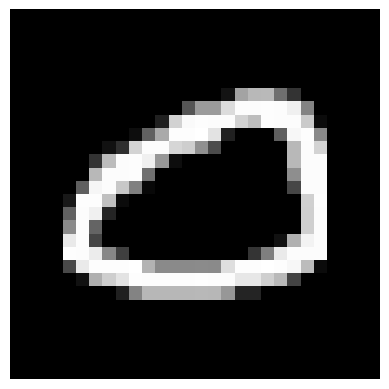

In [65]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])

pred = predict(x_test[idx].reshape(-1, 1))

print(f"El valor predicho es: {pred}")